# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: 

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:26<00:00, 6486503.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

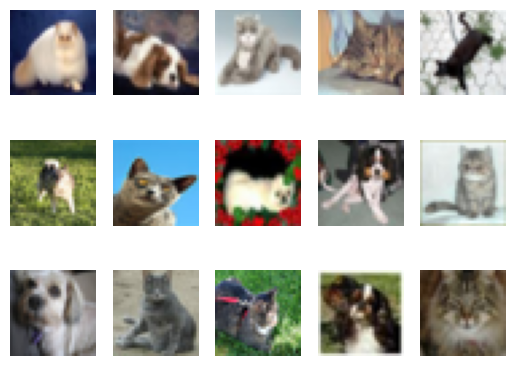

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [5]:
print("Training examples:", len(train_loader))
print("Validation examples:", len(val_loader))
print("Test examples:", len(test_loader))

Training examples: 8000
Validation examples: 2000
Test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
"""
We need a validation set when training our model to estimate the model's performance on unseen data ad to help prevent overfitting.

If we judge the performance of our models using only the training set loss, we risk of overfitting the training data, as model may memorize all the training data.
"""

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [7]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
#TODO: explain line 12, why pool again after pool?
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [13]:
for param in small_net.parameters():
    print(param.shape)
print("Total number of parameters in small_net:", sum([p.numel() for p in small_net.parameters()]))
print("Total number of parameters in large_net:", sum([p.numel() for p in large_net.parameters()]))

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
Total number of parameters in small_net: 386
Total number of parameters in large_net: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [14]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [15]:
print("default: batch_size=64, learning_rate=0.01, num_epochs=30")

default: batch_size=64, learning_rate=0.01, num_epochs=30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [20]:
# np.savetxt("{}_train_err.csv".format(model_path), train_err)
# np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
# np.savetxt("{}_val_err.csv".format(model_path), val_err)
# np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

print("model_small_bs64_lr0.01_epoch4_train_err.csv: training error at epoch 4 for hyperparameters batch_size=64, learning_rate=0.01 of the small network")
print("model_small_bs64_lr0.01_epoch4_train_loss.csv: training loss at epoch 4 for hyperparameters batch_size=64, learning_rate=0.01 of the small network") 
print("model_small_bs64_lr0.01_epoch4_val_err.csv: validation error at epoch 4 for hyperparameters batch_size=64, learning_rate=0.01 of the small network")
print("model_small_bs64_lr0.01_epoch4_val_loss.csv: validation loss at epoch 4 for hyperparameters batch_size=64, learning_rate=0.01 of the small network")

model_small_bs64_lr0.01_epoch4_train_err.csv: training error at epoch 4 for hyperparameters batch_size=64, learning_rate=0.01 of the small network
model_small_bs64_lr0.01_epoch4_train_loss.csv: training loss at epoch 4 for hyperparameters batch_size=64, learning_rate=0.01 of the small network
model_small_bs64_lr0.01_epoch4_val_err.csv: validation error at epoch 4 for hyperparameters batch_size=64, learning_rate=0.01 of the small network
model_small_bs64_lr0.01_epoch4_val_loss.csv: validation loss at epoch 4 for hyperparameters batch_size=64, learning_rate=0.01 of the small network


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [17]:
# # Since the function writes files to disk, you will need to mount
# # your Google Drive. If you are working on the lab locally, you
# # can comment out this code.
# 
# from google.colab import drive
# drive.mount('/content/gdrive')

In [52]:
# Train the small network, log the time taken
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.271375, Train loss: 0.5356965074539185 |Validation err: 0.2985, Validation loss: 0.5700085395947099
Epoch 2: Train err: 0.27025, Train loss: 0.5331112551689148 |Validation err: 0.291, Validation loss: 0.5680976780131459
Epoch 3: Train err: 0.266875, Train loss: 0.5335682244300842 |Validation err: 0.296, Validation loss: 0.5667871432378888
Epoch 4: Train err: 0.268125, Train loss: 0.5338350708484649 |Validation err: 0.292, Validation loss: 0.5728049809113145
Epoch 5: Train err: 0.26125, Train loss: 0.532977148771286 |Validation err: 0.3015, Validation loss: 0.569391111843288
Epoch 6: Train err: 0.268625, Train loss: 0.5307778398990631 |Validation err: 0.2945, Validation loss: 0.6006998065859079
Epoch 7: Train err: 0.268625, Train loss: 0.5363388571739197 |Validation err: 0.2925, Validation loss: 0.5690721040591598
Epoch 8: Train err: 0.268625, Train loss: 0.5310139281749725 |Validation err:

In [53]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50275, Train loss: 0.6932324762344361 |Validation err: 0.509, Validation loss: 0.6932079512625933
Epoch 2: Train err: 0.506, Train loss: 0.6932485876083374 |Validation err: 0.509, Validation loss: 0.6932767368853092
Epoch 3: Train err: 0.502, Train loss: 0.6932530207633972 |Validation err: 0.509, Validation loss: 0.6932352222502232
Epoch 4: Train err: 0.496, Train loss: 0.6932316331863403 |Validation err: 0.491, Validation loss: 0.6929545570164919
Epoch 5: Train err: 0.50575, Train loss: 0.6933202590942383 |Validation err: 0.509, Validation loss: 0.6931950710713863
Epoch 6: Train err: 0.49925, Train loss: 0.6932505393028259 |Validation err: 0.509, Validation loss: 0.6931738555431366
Epoch 7: Train err: 0.4995, Train loss: 0.6933198680877686 |Validation err: 0.509, Validation loss: 0.6933926846832037
Epoch 8: Train err: 0.5015, Train loss: 0.693265576839447 |Validation err: 0.509, Validatio

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

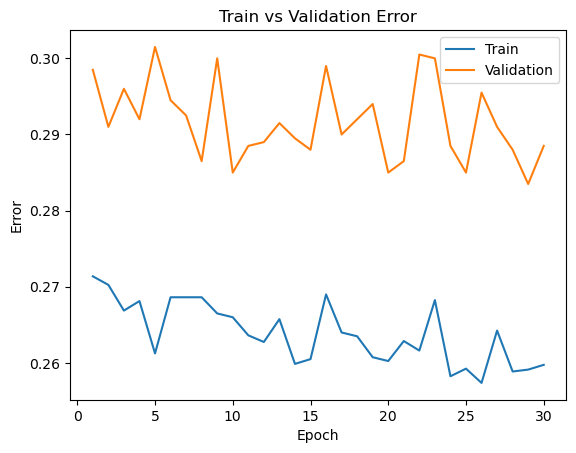

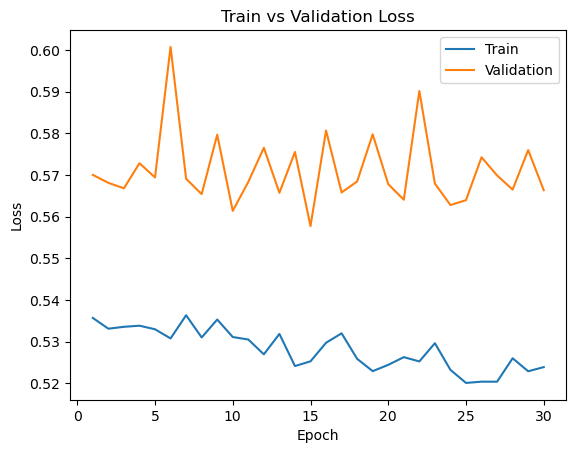

In [54]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
plot_training_curve(get_model_name("small", 64, 0.01, 29))

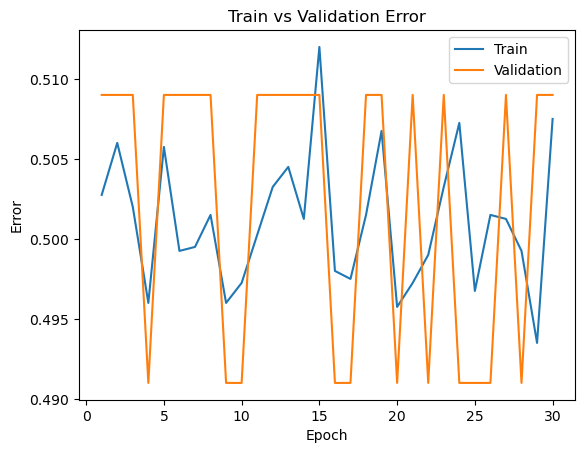

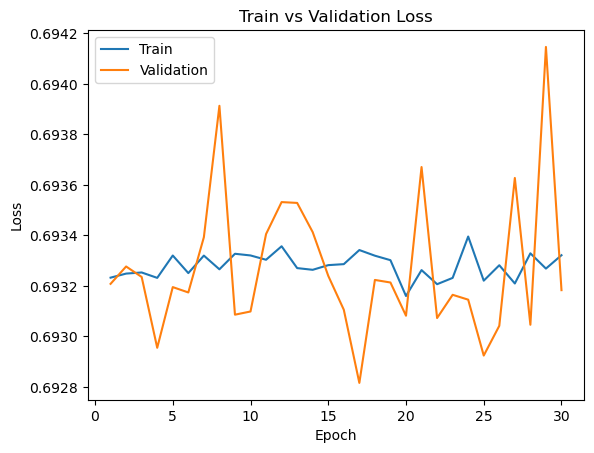

In [55]:
plot_training_curve(get_model_name("large", 64, 0.01, 29))

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
"""
The training error for both the small and large networks are going down as the number of epoch increases, but the validation error plateaus after some epoches. 
For the large network, the validation loss even increased near the end of the training, which is a sign of overfitting.
"""

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [23]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360018730163 |Validation err: 0.467, Validation loss: 0.692468661814928
Epoch 2: Train err: 0.448625, Train loss: 0.6922589745521546 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544506877661
Epoch 4: Train err: 0.430125, Train loss: 0.690861379146576 |Validation err: 0.424, Validation loss: 0.6896596644073725
Epoch 5: Train err: 0.434125, Train loss: 0.6899197192192078 |Validation err: 0.4195, Validation loss: 0.688694080337882
Epoch 6: Train err: 0.435875, Train loss: 0.6887418179512024 |Validation err: 0.4195, Validation loss: 0.6867832597345114
Epoch 7: Train err: 0.437, Train loss: 0.687377763748169 |Validation err: 0.4185, Validation loss: 0.6851978972554207
Epoch 8: Train err: 0.437375, Train loss: 0.6859268231391906 |Validation err: 0.4

The model takes longer to train with learning_rate=0.001 than with learning_rate=0.01


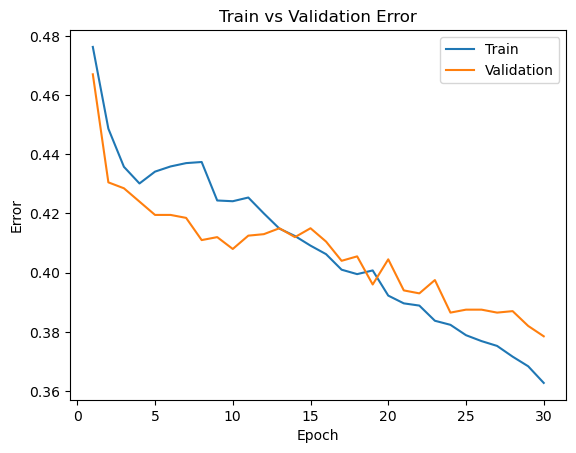

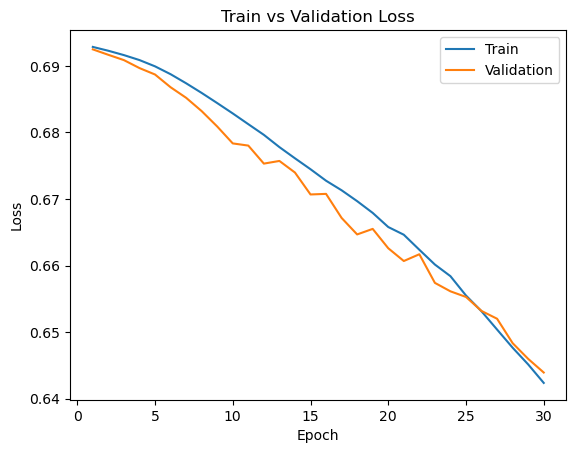

The effect of lowering the learning rate is that the model takes longer to train. The testing and validation error are higher than with learning_rate=0.01. The training and validation losses are higher than with learning_rate=0.01. The testing and validation losses start at the same number as the original one, but unlike the previous run, the validation error and loss both decrease as the number of epoch increases.


In [36]:
print("The model takes longer to train with learning_rate=0.001 than with learning_rate=0.01")
plot_training_curve(get_model_name("large", 64, 0.001, 29))
print("The effect of lowering the learning rate is that the model takes longer to train. The testing and validation error are higher than with learning_rate=0.01. The training and validation losses are higher than with learning_rate=0.01. The testing and validation losses start at the same number as the original one, but unlike the previous run, the validation error and loss both decrease as the number of epoch increases.")

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [24]:
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.39175, Train loss: 0.6541496052742004 |Validation err: 0.348, Validation loss: 0.6193344909697771
Epoch 2: Train err: 0.358, Train loss: 0.6271269545555115 |Validation err: 0.377, Validation loss: 0.6481302957981825
Epoch 3: Train err: 0.341875, Train loss: 0.6143617582321167 |Validation err: 0.342, Validation loss: 0.650497529655695
Epoch 4: Train err: 0.33475, Train loss: 0.6077601161003113 |Validation err: 0.3415, Validation loss: 0.6151808863505721
Epoch 5: Train err: 0.322625, Train loss: 0.5943540418148041 |Validation err: 0.3355, Validation loss: 0.6054878309369087
Epoch 6: Train err: 0.308875, Train loss: 0.573636647939682 |Validation err: 0.3315, Validation loss: 0.6263145208358765
Epoch 7: Train err: 0.30175, Train loss: 0.5685200216770172 |Validation err: 0.3285, Validation loss: 0.6119178989902139
Epoch 8: Train err: 0.29225, Train loss: 0.5556752805709839 |Validation err: 0.33

The model takes about the same time to train with learning_rate=0.1 than with learning_rate=0.01


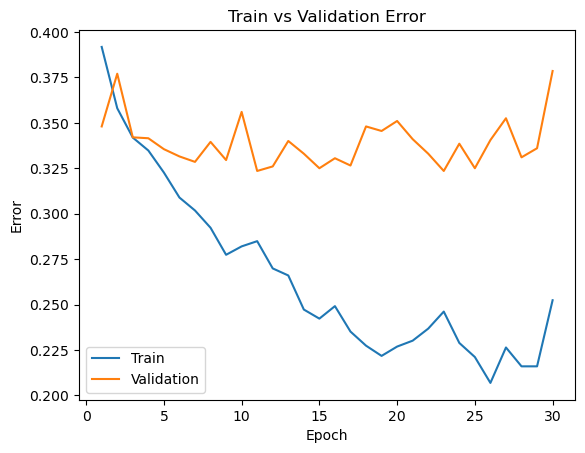

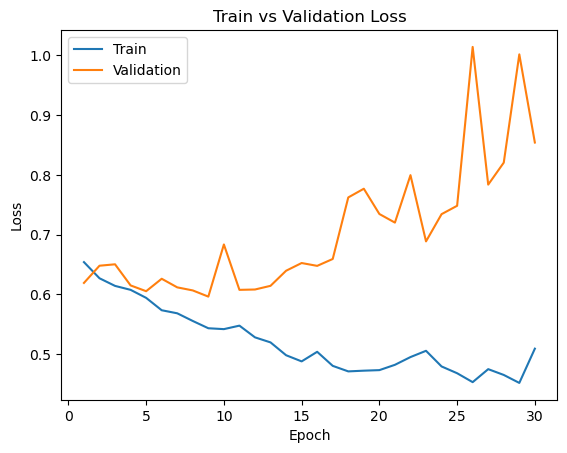

The effect of increasing the learning rate is that the model takes about the same time to train. The training and validation error starts lower than the original one but don't decrease as much as the original one as the number of epoch increases. The training and validation loss also starts higher. The validation error and loss both plateaued, and the validation loss is increasing as the number of epoch increases, exceeding the original one.


In [34]:
print("The model takes about the same time to train with learning_rate=0.1 than with learning_rate=0.01")
plot_training_curve(get_model_name("large", 64, 0.1, 29))
print("The effect of increasing the learning rate is that the model takes about the same time to train. The training and validation error starts lower than the original one but don't decrease as much as the original one as the number of epoch increases. The training and validation loss also starts higher. The validation error and loss both plateaued, and the validation loss is increasing as the number of epoch increases, exceeding the original one.")

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [25]:
train_net(large_net, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.28225, Train loss: 0.5570806879550219 |Validation err: 0.3705, Validation loss: 0.7909026145935059
Epoch 2: Train err: 0.268875, Train loss: 0.504723833873868 |Validation err: 0.366, Validation loss: 0.7550784051418304
Epoch 3: Train err: 0.257375, Train loss: 0.4788508042693138 |Validation err: 0.36, Validation loss: 0.7589615285396576
Epoch 4: Train err: 0.246125, Train loss: 0.4594662133604288 |Validation err: 0.3545, Validation loss: 0.7726107537746429
Epoch 5: Train err: 0.2375, Train loss: 0.4455264788120985 |Validation err: 0.3505, Validation loss: 0.7868674844503403
Epoch 6: Train err: 0.225, Train loss: 0.4288687389343977 |Validation err: 0.347, Validation loss: 0.7979879379272461
Epoch 7: Train err: 0.21725, Train loss: 0.4145100452005863 |Validation err: 0.342, Validation loss: 0.8122195303440094
Epoch 8: Train err: 0.2095, Train loss: 0.40172007866203785 |Validation err: 0.34, 

The model takes shorter to train with batch_size=512 than with batch_size=64


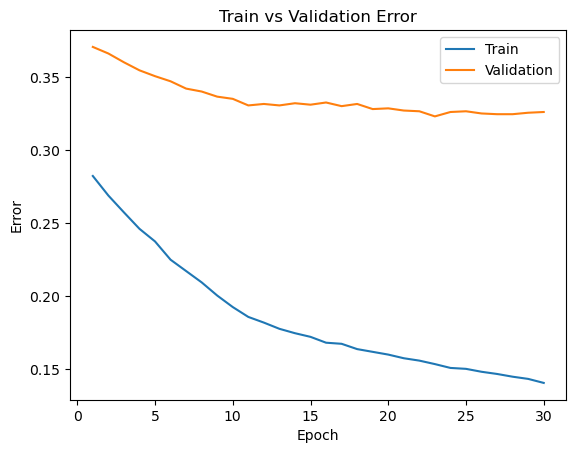

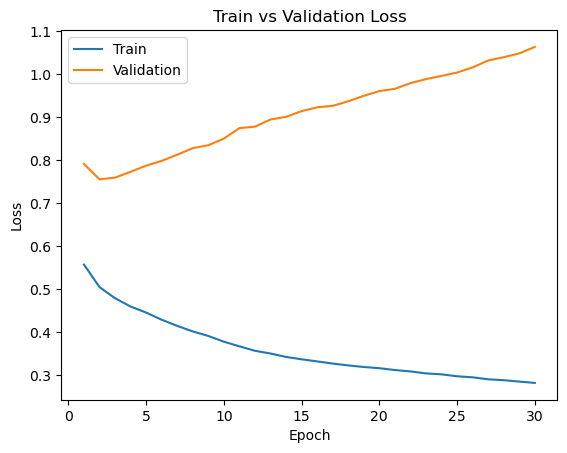

The most significant effect is that the error and loss curves are both a lot smoother with batch_size=512 than with batch_size=64. The test and validation error starts lower than the original one but ended up about the same. The test error starts lower than the original on. In contract, the validation loss starts higher than the original one and is increasing as the number of epoch increases.


In [35]:
print("The model takes shorter to train with batch_size=512 than with batch_size=64")
plot_training_curve(get_model_name("large", 512, 0.01, 29))
print("The most significant effect is that the error and loss curves are both a lot smoother with batch_size=512 than with batch_size=64. The test and validation error starts lower than the original one but ended up about the same. The test error starts lower than the original on. In contract, the validation loss starts higher than the original one and is increasing as the number of epoch increases.")

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [26]:
train_net(large_net, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.163, Train loss: 0.3348681270480156 |Validation err: 0.3365, Validation loss: 0.9873809589147567
Epoch 2: Train err: 0.145, Train loss: 0.2960944257378578 |Validation err: 0.323, Validation loss: 1.167094438791275
Epoch 3: Train err: 0.127625, Train loss: 0.2694824038259685 |Validation err: 0.323, Validation loss: 1.1877229628562926
Epoch 4: Train err: 0.117875, Train loss: 0.24751818135380746 |Validation err: 0.3205, Validation loss: 1.2629394266605378
Epoch 5: Train err: 0.116125, Train loss: 0.2523351505175233 |Validation err: 0.3195, Validation loss: 1.3112742629051208
Epoch 6: Train err: 0.11175, Train loss: 0.23896355969458818 |Validation err: 0.321, Validation loss: 1.490951668858528
Epoch 7: Train err: 0.104, Train loss: 0.2303946335222572 |Validation err: 0.3055, Validation loss: 1.4275583337545394
Epoch 8: Train err: 0.09775, Train loss: 0.2212852659979835 |Validation err: 0.321,

The model takes longer to train with batch_size=16 than with batch_size=64


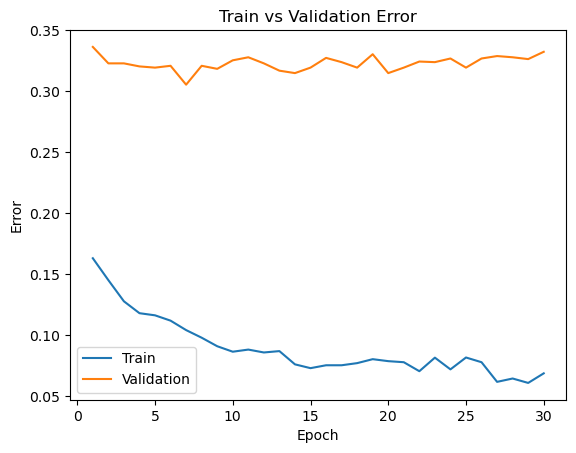

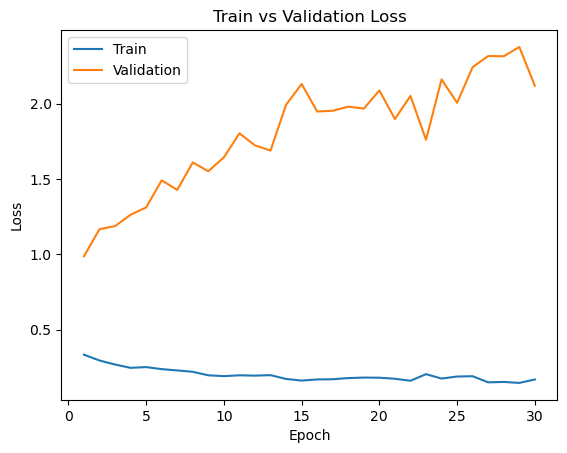

The testing error and loss are both lower than the original one, but the validation error and loss are higher than the original one and both plateaued. The validation error starts lower than the original one and doesn't change as the number of epoch increases. The validation loss starts higher than the original one and is increasing as the number of epoch increases.


In [37]:
print("The model takes longer to train with batch_size=16 than with batch_size=64")
plot_training_curve(get_model_name("large", 16, 0.01, 29))
print("The testing error and loss are both lower than the original one, but the validation error and loss are higher than the original one and both plateaued. The validation error starts lower than the original one and doesn't change as the number of epoch increases. The validation loss starts higher than the original one and is increasing as the number of epoch increases.")


## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [39]:
"""Based on the previous experiments, I would choose the following hyperparameters:

Batch size: 128
Learning rate: 0.005

Justification:
Batch size: 128
We observed that a batch size of 512 led to smoother training curves but also increased validation loss over time.
A batch size of 16 resulted in noisy training and high validation loss.
A batch size of 64 (the original default) performed reasonably well.
Choosing 128 as a middle ground between 64 and 512 aims to balance the benefits of larger batch sizes (more stable gradients) with the advantages of smaller ones (better generalization).


Learning rate: 0.005
The original learning rate of 0.01 seemed to work well but showed some instability.
A learning rate of 0.001 was too slow, resulting in underperforming models.
A learning rate of 0.1 led to erratic behavior and poor performance.
Choosing 0.005 aims to find a balance - fast enough for efficient training but not so large as to cause instability."""

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [45]:
train_net(large_net, batch_size=128, learning_rate=0.005)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6936881125919403 |Validation err: 0.509, Validation loss: 0.6939872577786446
Epoch 2: Train err: 0.49775, Train loss: 0.6932644257469783 |Validation err: 0.509, Validation loss: 0.6933849528431892
Epoch 3: Train err: 0.49775, Train loss: 0.6931906664182269 |Validation err: 0.509, Validation loss: 0.6933559030294418
Epoch 4: Train err: 0.49775, Train loss: 0.6931810871003166 |Validation err: 0.509, Validation loss: 0.6933058612048626
Epoch 5: Train err: 0.49775, Train loss: 0.6931503443490892 |Validation err: 0.509, Validation loss: 0.693209633231163
Epoch 6: Train err: 0.49775, Train loss: 0.6931699883370173 |Validation err: 0.509, Validation loss: 0.6932038515806198
Epoch 7: Train err: 0.508, Train loss: 0.6931906181668478 |Validation err: 0.509, Validation loss: 0.6931889653205872
Epoch 8: Train err: 0.50375, Train loss: 0.6932025580179124 |Validation err: 0.509, Val

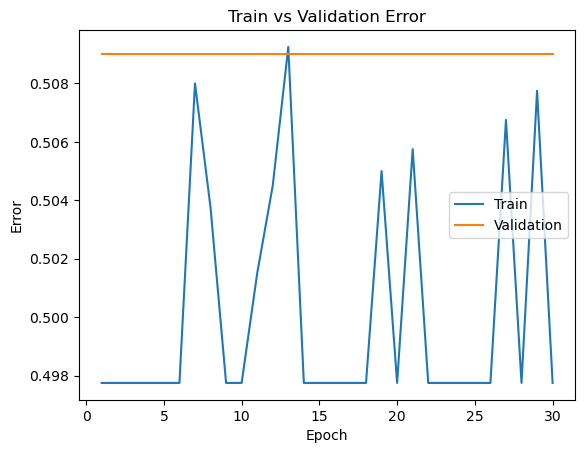

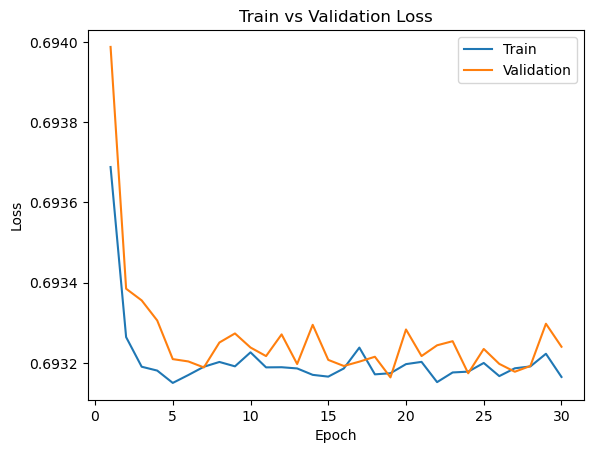

In [46]:
plot_training_curve(get_model_name("large", 128, 0.005, 29))

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [47]:
"""
Batch size: 256
Learning rate: 0.001

Justification:

Increasing the batch size from 128 to 256 should help stabilize the training process.
The current batch size of 128 is resulting in extremely volatile training error.
A larger batch size should provide more stable gradient estimates and smoother training curves.

Learning rate: 0.001

The current learning rate of 0.005 seems too high, causing instability in training.
Reducing it to 0.001 should allow for more careful parameter updates.
This may help the model actually learn and improve its performance on the validation set.
"""

'\nBatch size: 256\nLearning rate: 0.001\n\nJustification:\n\nIncreasing the batch size from 128 to 256 should help stabilize the training process.\nThe current batch size of 128 is resulting in extremely volatile training error.\nA larger batch size should provide more stable gradient estimates and smoother training curves.\n\nLearning rate: 0.001\n\nThe current learning rate of 0.005 seems too high, causing instability in training.\nReducing it to 0.001 should allow for more careful parameter updates.\nThis may help the model actually learn and improve its performance on the validation set.\n'

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [48]:
train_net(large_net, batch_size=256, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6931420266628265 |Validation err: 0.509, Validation loss: 0.6932450383901596
Epoch 2: Train err: 0.49775, Train loss: 0.6931191198527813 |Validation err: 0.509, Validation loss: 0.6932293623685837
Epoch 3: Train err: 0.49775, Train loss: 0.6931407302618027 |Validation err: 0.509, Validation loss: 0.6932470798492432
Epoch 4: Train err: 0.49775, Train loss: 0.6931497976183891 |Validation err: 0.509, Validation loss: 0.6932648792862892
Epoch 5: Train err: 0.49775, Train loss: 0.6931307520717382 |Validation err: 0.509, Validation loss: 0.6932354867458344
Epoch 6: Train err: 0.49775, Train loss: 0.6931509114801884 |Validation err: 0.509, Validation loss: 0.693235456943512
Epoch 7: Train err: 0.49775, Train loss: 0.6931505259126425 |Validation err: 0.509, Validation loss: 0.6932464987039566
Epoch 8: Train err: 0.49775, Train loss: 0.6931538842618465 |Validation err: 0.509, V

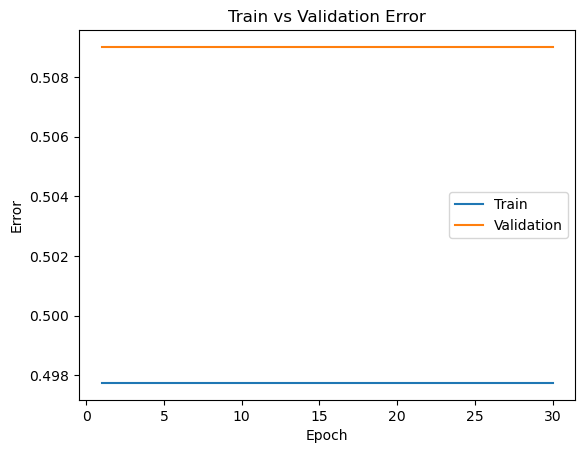

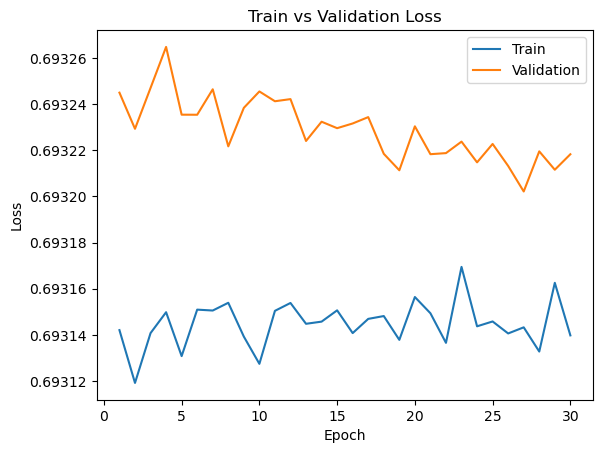

In [49]:
plot_training_curve(get_model_name("large", 256, 0.001, 29))

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [61]:
small_net = SmallNet()
model_path = get_model_name(small_net.name, batch_size=64, learning_rate=0.01, epoch=29)
state = torch.load(model_path)
small_net.load_state_dict(state)

/tmp/ipykernel_62251/2965234102.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [62]:
# The original large model is the best model
# plot_training_curve(get_model_name("large", 64, 0.01, 29))
large_net = LargeNet()
model_path = get_model_name(large_net.name, batch_size=64, learning_rate=0.01, epoch=25)
state = torch.load(model_path)
large_net.load_state_dict(state)


/tmp/ipykernel_62251/326948028.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [58]:
"""
For the small model. The validation loss and validation error both decreases as the number of epoch increases. The validation error and loss are both lower than the original one. The testing error and loss are both lower than the original one. Thus we load the last epoch of the small model.

For the large model. The original model is the one that has the smallest validation error and validation loss. We choose the epoch 25 because after this point the validation loss starts to increase, which is a sign of overfitting.
"""

'\nFor the small model. The validation loss and validation error both decreases as the number of epoch increases. The validation error and loss are both lower than the original one. The testing error and loss are both lower than the original one. Thus we load the last epoch of the small model.\n\nFor the large model. The original model is the one that has the smallest validation error and validation loss. We choose the epoch 25 because after this point the validation loss starts to increase, which is a sign of overfitting.\n'

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [64]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

# We first test the small model
err, loss = evaluate(small_net, test_loader, nn.BCEWithLogitsLoss())
print("Small model test error:", err)
print("Small model test loss:", loss)

err, loss = evaluate(small_net, val_loader, nn.BCEWithLogitsLoss())
print("Small model validation error:", err)
print("Small model validation loss:", loss)

# Then we test the large model
err, loss = evaluate(large_net, test_loader, nn.BCEWithLogitsLoss())
print("Large model test error:", err)
print("Large model test loss:", loss)

err, loss = evaluate(large_net, val_loader, nn.BCEWithLogitsLoss())
print("Large model validation error:", err)
print("Large model validation loss:", loss)


Files already downloaded and verified
Files already downloaded and verified
Small model test error: 0.2825
Small model test loss: 0.5455703968182206
Small model validation error: 0.2885
Small model validation loss: 0.5680948803201318
Large model test error: 0.5
Large model test loss: 0.6931164693087339
Large model validation error: 0.491
Large model validation loss: 0.6929669193923473


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [66]:
"""
The small model outperforms the large model on both test and validation sets.
The small model has lower error rates (around 28-29%) compared to the large model (around 49-50%).
The loss values for the small model are also lower than those of the large model, indicating better overall performance.
The large model's performance is close to random guessing (50% error rate), suggesting it may not have learned useful patterns from the data.
The small model shows slight overfitting (validation metrics slightly worse than test metrics).

The validation set is used during the model development process to tune hyperparameters and make model selection decisions. This can lead to overfitting to the validation set. On the another hand, the test set is completely held out and not used in any way during model development. Thus we would expect the test error to be higher than the validation error.
"""

"\nThe small model outperforms the large model on both test and validation sets.\nThe small model has lower error rates (around 28-29%) compared to the large model (around 49-50%).\nThe loss values for the small model are also lower than those of the large model, indicating better overall performance.\nThe large model's performance is close to random guessing (50% error rate), suggesting it may not have learned useful patterns from the data.\nThe small model shows slight overfitting (validation metrics slightly worse than test metrics).\n\nThe validation set is used during the model development process to tune hyperparameters and make model selection decisions. This can lead to overfitting to the validation set. On the another hand, the test set is completely held out and not used in any way during model development. Thus we would expect the test error to be higher than the validation error.\n"

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [67]:
"""
Because the test data is used to evaluate the model's performance on unseen data. If we use the test data to tune the model, we risk overfitting the test data. We should use the test data as little as possible to ensure that the model is generalizing well to unseen data.
"""

"\nBecause the test data is used to evaluate the model's performance on unseen data. If we use the test data to tune the model, we risk overfitting the test data. We should use the test data as little as possible to ensure that the model is generalizing well to unseen data.\n"

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [115]:
# #TODO: explain line 12, why pool again after pool?
# class SmallNet(nn.Module):
#     def __init__(self):
#         super(SmallNet, self).__init__()
#         self.name = "small"
#         self.conv = nn.Conv2d(3, 5, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc = nn.Linear(5 * 7 * 7, 1)
# 
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv(x)))
#         x = self.pool(x)
#         x = x.view(-1, 5 * 7 * 7)
#         x = self.fc(x)
#         x = x.squeeze(1) # Flatten to [batch_size]
#         return x

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)

    def forward(self, img):
        # img shape is now [batch_size, 3, 32, 32]

        # Combine the three color layers into one
        grayscale_img = img.sum(dim=1, keepdim=True)
        # grayscale_img shape: [batch_size, 1, 32, 32]

        # Flatten the image
        flattened = grayscale_img.view(img.size(0), -1)
        # flattened shape: [batch_size, 32 * 32]

        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)

        return activation2.squeeze(1)

# class Pigeon(nn.Module):
#     def __init__(self):
#         super(Pigeon, self).__init__()
#         self.name = "pigeon"
#         self.layer1 = nn.Linear(3 * 32 * 32, 30)  # Changed input size to 3 * 32 * 32
#         self.layer2 = nn.Linear(30, 1)
#     
#     def forward(self, img):
#         # img shape is [batch_size, 3, 32, 32]
#         
#         # Flatten the image
#         flattened = img.view(img.size(0), -1)
#         # flattened shape: [batch_size, 3 * 32 * 32]
#         
#         activation1 = F.relu(self.layer1(flattened))
#         activation2 = self.layer2(activation1)
#         
#         return activation2.squeeze(1)  # Ensure output is [batch_size]



# Train the pigeon model
pigeon = Pigeon()
train_net(pigeon, batch_size=128, learning_rate=0.001)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4415, Train loss: 0.6824160152011447 |Validation err: 0.4125, Validation loss: 0.6730756685137749
Epoch 2: Train err: 0.40825, Train loss: 0.6644414218645247 |Validation err: 0.407, Validation loss: 0.6628190837800503
Epoch 3: Train err: 0.396, Train loss: 0.656968631441631 |Validation err: 0.412, Validation loss: 0.6605729125440121
Epoch 4: Train err: 0.39175, Train loss: 0.6515530877643161 |Validation err: 0.417, Validation loss: 0.6580286510288715
Epoch 5: Train err: 0.385375, Train loss: 0.6472549220872303 |Validation err: 0.4135, Validation loss: 0.6559516973793507
Epoch 6: Train err: 0.383375, Train loss: 0.6436542565860446 |Validation err: 0.421, Validation loss: 0.6552898958325386
Epoch 7: Train err: 0.379375, Train loss: 0.6406074771805416 |Validation err: 0.414, Validation loss: 0.653636921197176
Epoch 8: Train err: 0.37475, Train loss: 0.6374386520612807 |Validation err: 0.4175,

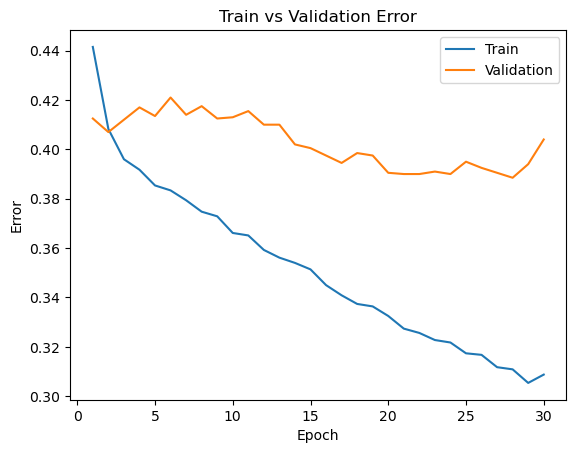

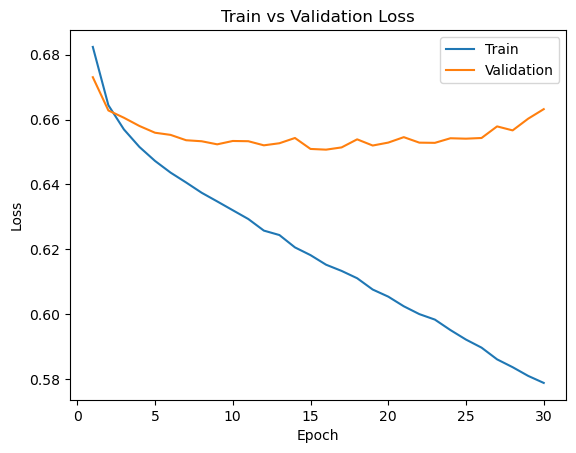

'\nThe CNN model outperforms the ANN model on both test and validation sets. The ANN validation error is around 35-40%, while the CNN validation error is around 25-30%. The ANN model is also slower to train and has higher loss values than the CNN model. This suggests that the CNN model is better at learning the patterns in the data and generalizing to unseen examples. There is barely any decrease in the ANN validation error and loss.\n'

In [117]:
# plot the training curve
plot_training_curve(get_model_name("pigeon", 128, 0.001, 29))

"""
The CNN model outperforms the ANN model on both test and validation sets. The ANN validation error is around 35-40%, while the CNN validation error is around 25-30%. The ANN model is also slower to train and has higher loss values than the CNN model. This suggests that the CNN model is better at learning the patterns in the data and generalizing to unseen examples. There is barely any decrease in the ANN validation error and loss.
"""

tensor([[[0.9765, 0.9765, 0.9765],
         [0.9647, 0.9647, 0.9686],
         [0.9686, 0.9686, 0.9765],
         ...,
         [0.9922, 0.9686, 0.9765],
         [0.9922, 0.9686, 0.9765],
         [1.0000, 0.9843, 0.9961]],

        [[0.9569, 0.9569, 0.9569],
         [0.9490, 0.9490, 0.9529],
         [0.9490, 0.9490, 0.9569],
         ...,
         [0.9647, 0.9451, 0.9490],
         [0.9725, 0.9490, 0.9490],
         [0.9961, 0.9725, 0.9765]],

        [[0.9608, 0.9608, 0.9608],
         [0.9490, 0.9490, 0.9529],
         [0.9529, 0.9529, 0.9608],
         ...,
         [0.9451, 0.9216, 0.9020],
         [0.9647, 0.9451, 0.9373],
         [0.9843, 0.9608, 0.9686]],

        ...,

        [[0.5765, 0.3176, 0.1725],
         [0.5843, 0.3216, 0.1804],
         [0.5843, 0.3176, 0.1804],
         ...,
         [0.9765, 0.9647, 0.9686],
         [0.9804, 0.9608, 0.9647],
         [1.0000, 0.9804, 0.9882]],

        [[0.6588, 0.3882, 0.2275],
         [0.6392, 0.3647, 0.2118],
         [0.

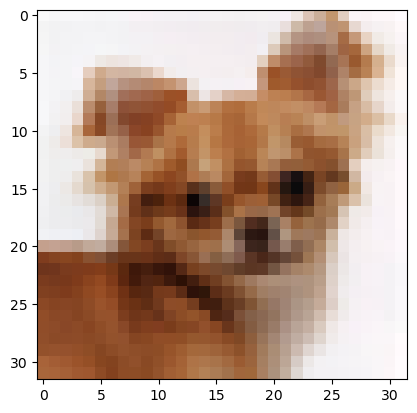

In [80]:
# check the size of test sample 1
img = None
for images, labels in test_loader:
    # plot it 
    img = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(img, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.imshow(img)
    print(img)
    break

# since the image has a torch.Size([64, 3, 32, 32])
# 64 is the batch size, 3 is the number of color channels, 32 is the height and 32 is the width



In [104]:
# check the size of the img
img.size()

# turn the image into a [32,32,1] tensor by combining the three color layers
grayscale_img = img.mean(dim=2, keepdim=True)

grayscale_img.size()

torch.Size([32, 32, 1])

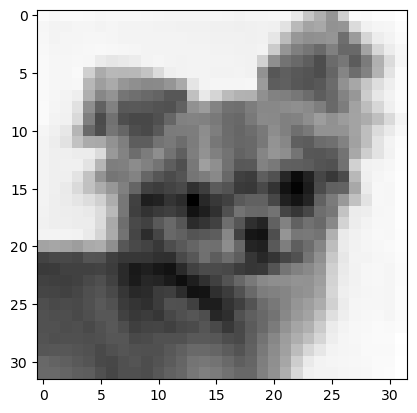

In [105]:
# display the grayscale image
plt.imshow(grayscale_img.squeeze(), cmap='gray')

torch.Size([1, 32, 32])


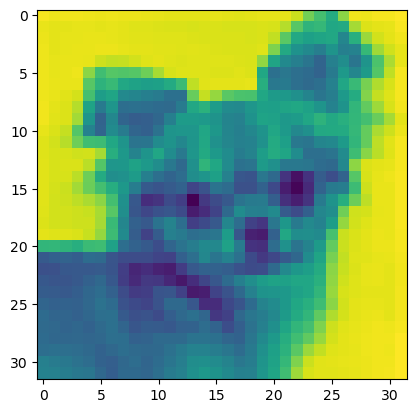

In [112]:
# use torchvision.rgb_to_grayscale to convert the image to grayscale
import torchvision.transforms.functional as TF

# make the rgb channel first 
img_permute = img.permute(2, 0, 1)

grayscale_img = TF.rgb_to_grayscale(img_permute)

print(grayscale_img.size())
plt.imshow(grayscale_img.squeeze(), cmap='gray')
